# Imports

In [680]:
import numpy as np
import pandas as pd
import xlrd
import os
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, Normalizer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, KMeansSMOTE, ADASYN, RandomOverSampler, SMOTENC
from imblearn.combine import SMOTEENN
from imblearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn import set_config
import warnings
warnings.filterwarnings("ignore")
import time
import itertools


# Inspection

## import csv

In [356]:
df = pd.read_csv("data/ObesityDataSet_raw_and_data_sinthetic.csv")
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## check NA

In [357]:
df.isna().sum().sum()

0

## Check correlation

In [358]:
df.corr()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
Age,1.000000,-0.025958,0.202560,0.016291,-0.043944,-0.045304,-0.144938,-0.296931
Height,-0.025958,1.000000,0.463136,-0.038121,0.243672,0.213376,0.294709,0.051912
Weight,0.202560,0.463136,1.000000,0.216125,0.107469,0.200575,-0.051436,-0.071561
FCVC,0.016291,-0.038121,0.216125,1.000000,0.042216,0.068461,0.019939,-0.101135
NCP,-0.043944,0.243672,0.107469,0.042216,1.000000,0.057088,0.129504,0.036326
CH2O,-0.045304,0.213376,0.200575,0.068461,0.057088,1.000000,0.167236,0.011965
FAF,-0.144938,0.294709,-0.051436,0.019939,0.129504,0.167236,1.000000,0.058562
TUE,-0.296931,0.051912,-0.071561,-0.101135,0.036326,0.011965,0.058562,1.000000


## Round synthetic data to corrrespond to questionaire

In [359]:
cols_to_round= ["FCVC", "NCP", "CH2O", "FAF", "TUE", "Age"]

def column_rounder(df, cols):
    for col in cols:
        df[col] = df[col].round(0)
    return df

df[cols_to_round] = column_rounder(df[cols_to_round], cols_to_round)
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## Check value counts

In [360]:
[display(df[i].value_counts()) for i in df.columns]

Male      1068
Female    1043
Name: Gender, dtype: int64

21.0    236
23.0    218
26.0    213
18.0    212
19.0    169
22.0    163
20.0    150
24.0     95
25.0     82
17.0     69
31.0     62
30.0     53
27.0     43
33.0     37
38.0     34
29.0     33
34.0     29
32.0     26
39.0     25
37.0     24
28.0     20
16.0     20
41.0     20
40.0     19
35.0     19
36.0      6
44.0      6
42.0      6
55.0      5
43.0      3
45.0      3
46.0      2
51.0      2
15.0      1
56.0      1
14.0      1
52.0      1
48.0      1
61.0      1
47.0      1
Name: Age, dtype: int64

1.700000    60
1.650000    50
1.600000    43
1.750000    39
1.620000    36
            ..
1.680762     1
1.819875     1
1.530248     1
1.654067     1
1.885543     1
Name: Height, Length: 1574, dtype: int64

80.000000     59
70.000000     43
50.000000     42
75.000000     40
60.000000     37
              ..
90.138680      1
89.738596      1
115.828167     1
108.721893     1
122.119682     1
Name: Weight, Length: 1525, dtype: int64

yes    1726
no      385
Name: family_history_with_overweight, dtype: int64

yes    1866
no      245
Name: FAVC, dtype: int64

2.0    1013
3.0     996
1.0     102
Name: FCVC, dtype: int64

3.0    1470
1.0     316
2.0     176
4.0     149
Name: NCP, dtype: int64

Sometimes     1765
Frequently     242
Always          53
no              51
Name: CAEC, dtype: int64

no     2067
yes      44
Name: SMOKE, dtype: int64

2.0    1110
3.0     516
1.0     485
Name: CH2O, dtype: int64

no     2015
yes      96
Name: SCC, dtype: int64

1.0    776
0.0    720
2.0    496
3.0    119
Name: FAF, dtype: int64

0.0    952
1.0    915
2.0    244
Name: TUE, dtype: int64

Sometimes     1401
no             639
Frequently      70
Always           1
Name: CALC, dtype: int64

Public_Transportation    1580
Automobile                457
Walking                    56
Motorbike                  11
Bike                        7
Name: MTRANS, dtype: int64

Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: NObeyesdad, dtype: int64

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## Manually encode that None response would be a 0

In [361]:
df.FCVC = [x-1 for x in df.FCVC]
df.FCVC.value_counts()

1.0    1013
2.0     996
0.0     102
Name: FCVC, dtype: int64

# Manual encode weight classes in order of severity

In [362]:
target_categories = {'Insufficient_Weight':0,
 'Normal_Weight':1,
 'Overweight_Level_I':2,
 'Overweight_Level_II':3,
 'Obesity_Type_I':4,
 'Obesity_Type_II':5,
 'Obesity_Type_III':6}

df.NObeyesdad = [target_categories[key] for key in df.NObeyesdad]
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,1.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,1
1,Female,21.0,1.52,56.0,yes,no,2.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,1
2,Male,23.0,1.80,77.0,yes,no,1.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,1
3,Male,27.0,1.80,87.0,no,no,2.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,2
4,Male,22.0,1.78,89.8,no,no,1.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,3


## Label encode

In [363]:
cols_to_le = ["Gender", "family_history_with_overweight", "FAVC", "SMOKE", "SCC", "MTRANS"]
for i in cols_to_le:
    le = LabelEncoder()
    df[i] = le.fit_transform(df[i])
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,21.0,1.62,64.0,1,0,1.0,3.0,Sometimes,0,2.0,0,0.0,1.0,no,3,1
1,0,21.0,1.52,56.0,1,0,2.0,3.0,Sometimes,1,3.0,1,3.0,0.0,Sometimes,3,1
2,1,23.0,1.80,77.0,1,0,1.0,3.0,Sometimes,0,2.0,0,2.0,1.0,Frequently,3,1
3,1,27.0,1.80,87.0,0,0,2.0,3.0,Sometimes,0,2.0,0,2.0,0.0,Frequently,4,2
4,1,22.0,1.78,89.8,0,0,1.0,1.0,Sometimes,0,2.0,0,0.0,0.0,Sometimes,3,3


# Train test split

In [442]:
col_to_drop = ["NObeyesdad", "Height", "Weight"] 
X = df.drop(columns=col_to_drop)
y = df["NObeyesdad"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)

## Inspect X train

In [443]:
X_train

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
442,1,26.0,1,1,1.0,3.0,Sometimes,0,2.0,0,0.0,1.0,Sometimes,4
253,0,26.0,1,1,1.0,1.0,Sometimes,0,2.0,0,0.0,2.0,Sometimes,3
554,1,16.0,0,1,1.0,2.0,Sometimes,0,3.0,0,1.0,0.0,Sometimes,3
1500,1,24.0,1,1,1.0,3.0,Sometimes,0,1.0,0,0.0,1.0,no,0
359,0,33.0,1,0,1.0,3.0,Sometimes,0,2.0,0,1.0,0.0,Sometimes,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,1,19.0,0,1,1.0,4.0,Frequently,0,2.0,0,3.0,1.0,Frequently,0
840,1,20.0,1,1,2.0,3.0,Sometimes,0,3.0,0,2.0,0.0,Sometimes,3
1794,1,31.0,1,1,2.0,2.0,Sometimes,0,1.0,0,1.0,1.0,no,3
155,0,31.0,1,1,2.0,1.0,Frequently,0,2.0,0,1.0,1.0,Sometimes,0


## Ordinal Encode

In [444]:
cols_to_ord = ["CAEC", "CALC"]

ord_enc = OrdinalEncoder(categories=[["no", "Sometimes", "Frequently", "Always"],
                                         ["no", "Sometimes", "Frequently", "Always"]])

X_train[cols_to_ord] = ord_enc.fit_transform(X_train[cols_to_ord])
X_test[cols_to_ord] = ord_enc.transform(X_test[cols_to_ord])
X_train.head()


,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
442,1,26.0,1,1,1.0,3.0,1.0,0,2.0,0,0.0,1.0,1.0,4
253,0,26.0,1,1,1.0,1.0,1.0,0,2.0,0,0.0,2.0,1.0,3
554,1,16.0,0,1,1.0,2.0,1.0,0,3.0,0,1.0,0.0,1.0,3
1500,1,24.0,1,1,1.0,3.0,1.0,0,1.0,0,0.0,1.0,0.0,0
359,0,33.0,1,0,1.0,3.0,1.0,0,2.0,0,1.0,0.0,1.0,3


In [445]:
X_train.corr()

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
Gender,1.000000,0.045974,0.095035,0.078526,-0.272743,0.081745,-0.092890,0.045388,0.056896,-0.098695,0.202470,0.015315,0.006922,-0.143400
Age,0.045974,1.000000,0.218257,0.083431,0.000779,-0.053270,-0.082336,0.094705,-0.034033,-0.121402,-0.127657,-0.283199,0.036785,-0.606381
family_history_with_overweight,0.095035,0.218257,1.000000,0.204672,0.009883,0.046047,-0.158420,0.003502,0.128790,-0.180247,-0.058395,0.024205,-0.029362,-0.106733
FAVC,0.078526,0.083431,0.204672,1.000000,-0.059913,-0.011639,-0.166281,-0.064057,0.012077,-0.199856,-0.118977,0.068491,0.119627,-0.079010
FCVC,-0.272743,0.000779,0.009883,-0.059913,1.000000,0.041271,0.069792,0.002427,0.052400,0.076476,0.021490,-0.087493,0.035553,0.083170
NCP,0.081745,-0.053270,0.046047,-0.011639,0.041271,1.000000,0.101231,0.005585,0.052512,0.000133,0.130696,0.004125,0.074801,-0.065573
CAEC,-0.092890,-0.082336,-0.158420,-0.166281,0.069792,0.101231,1.000000,0.055045,-0.121622,0.102785,0.034518,0.043418,-0.058633,0.043745
SMOKE,0.045388,0.094705,0.003502,-0.064057,0.002427,0.005585,0.055045,1.000000,-0.027992,0.066177,0.019631,0.018467,0.091905,-0.033637
CH2O,0.056896,-0.034033,0.128790,0.012077,0.052400,0.052512,-0.121622,-0.027992,1.000000,-0.005737,0.099436,-0.036897,0.096333,0.058086
SCC,-0.098695,-0.121402,-0.180247,-0.199856,0.076476,0.000133,0.102785,0.066177,-0.005737,1.000000,0.070929,-0.016485,-0.008174,0.044821


In [446]:
X_train.FCVC.value_counts()

1.0    817
2.0    789
0.0     82
Name: FCVC, dtype: int64

## Normalize Age

In [447]:
X_train["Age"] = [np.log(x) for x in X_train["Age"]]


<AxesSubplot:xlabel='Age'>

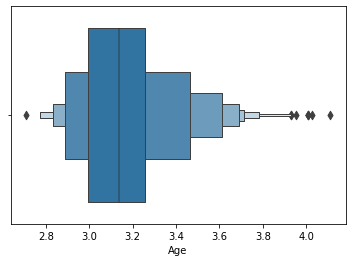

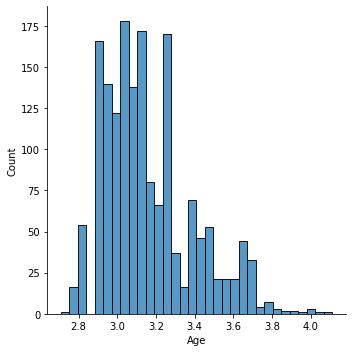

In [448]:
display(sns.boxenplot(X_train.Age))
display(sns.displot(X_train.Age))

1    846
0    842
Name: Gender, dtype: int64

3.044522    178
3.135494    172
3.258097    170
2.890372    166
2.944439    140
3.091042    138
2.995732    122
3.178054     80
3.218876     66
2.833213     54
3.433987     46
3.401197     44
3.295837     37
3.496508     32
3.637586     28
3.367296     25
3.526361     21
3.465736     21
3.610918     21
3.713572     17
3.555348     17
3.663562     16
2.772589     16
3.332205     16
3.688879     16
3.784190      5
3.737670      4
3.583519      4
4.007333      3
3.761200      2
3.931826      2
3.828641      2
3.850148      1
3.806662      1
3.951244      1
4.110874      1
2.708050      1
4.025352      1
3.871201      1
Name: Age, dtype: int64

1    1383
0     305
Name: family_history_with_overweight, dtype: int64

1    1492
0     196
Name: FAVC, dtype: int64

1.0    817
2.0    789
0.0     82
Name: FCVC, dtype: int64

3.0    1166
1.0     255
2.0     146
4.0     121
Name: NCP, dtype: int64

1.0    1414
2.0     188
3.0      43
0.0      43
Name: CAEC, dtype: int64

0    1653
1      35
Name: SMOKE, dtype: int64

2.0    892
3.0    413
1.0    383
Name: CH2O, dtype: int64

0    1609
1      79
Name: SCC, dtype: int64

1.0    619
0.0    582
2.0    401
3.0     86
Name: FAF, dtype: int64

0.0    769
1.0    728
2.0    191
Name: TUE, dtype: int64

1.0    1108
0.0     520
2.0      59
3.0       1
Name: CALC, dtype: int64

3    1256
0     373
4      44
2       9
1       6
Name: MTRANS, dtype: int64

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

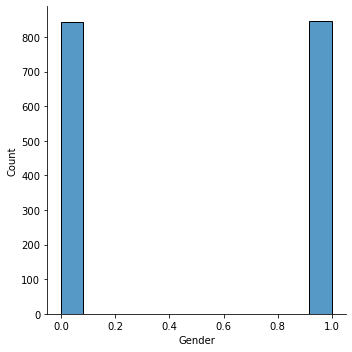

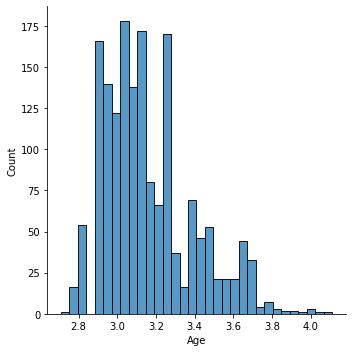

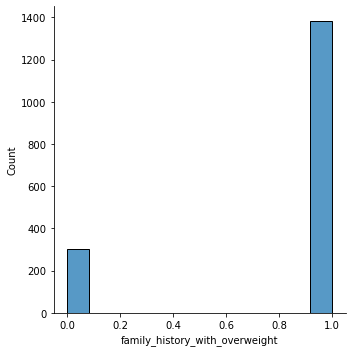

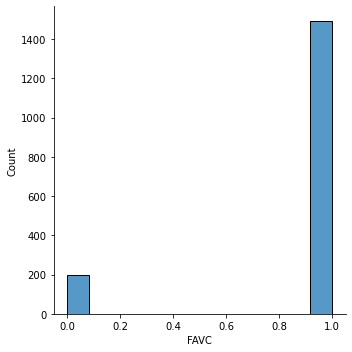

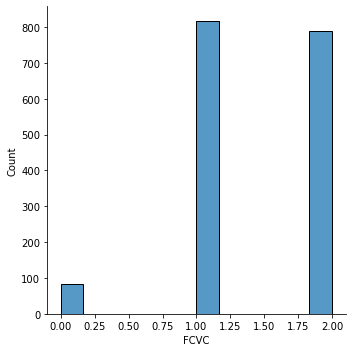

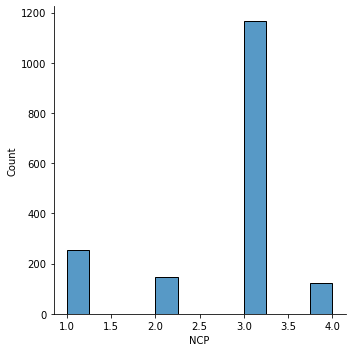

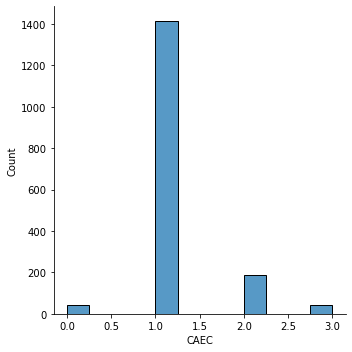

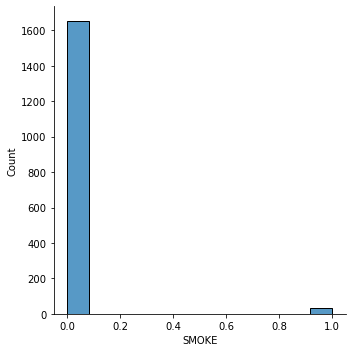

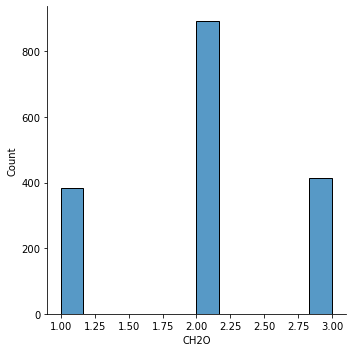

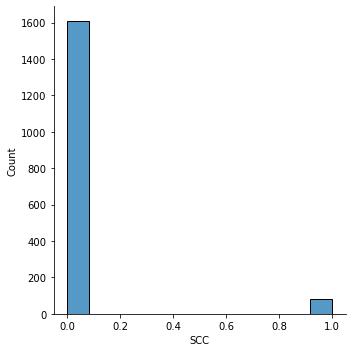

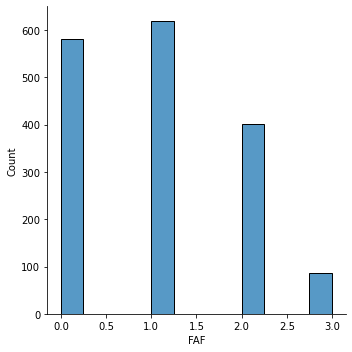

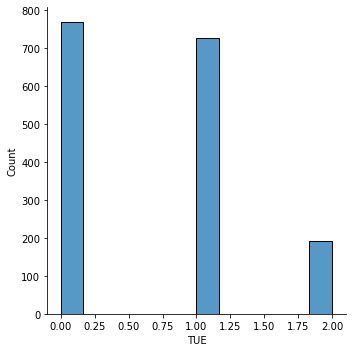

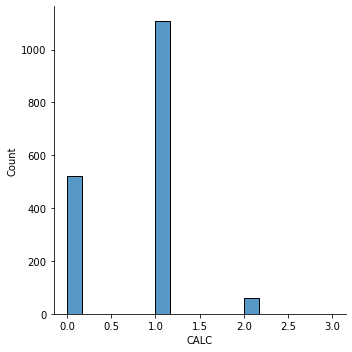

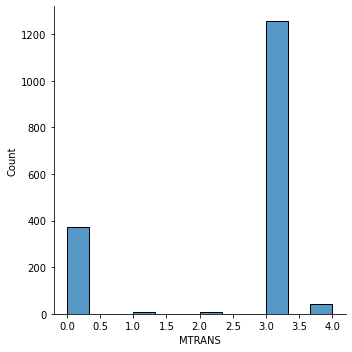

In [449]:
[display(sns.displot(X_train[x]), X_train[x].value_counts()) for x in list(X_train.columns)]


# Initial Models

## set config

In [451]:
# this will allow us to visualize the pipeline (may not be available in learn-env)
set_config(display= 'diagram')

## Base Model RF SS

{'rf__criterion': 'entropy',
 'rf__max_depth': 11,
 'rf__max_features': 'log2',
 'rf__n_estimators': 457}

0.7849577721981282

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(criterion='entropy', max_depth=11,
                                        max_features='log2', n_estimators=457,
                                        random_state=42))])

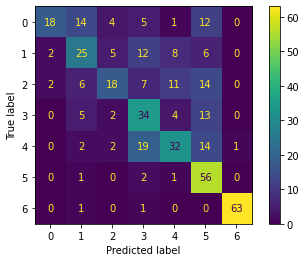

In [452]:
steps = [('std_scaler', StandardScaler()), ('rf', RandomForestClassifier(random_state=42))]

pipeline = Pipeline(steps)

# Train the pipeline (tranformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transfomers & trained predictor)
predicted = pipeline.predict(X_test)

pipe_grid = {
            "rf__n_estimators": [457],
            "rf__criterion": ["entropy"],
            "rf__max_depth": [11],
            "rf__max_features": ["log2"]
            }

# note: default scoring is aaccuracy
second_pipe = GridSearchCV(estimator = pipeline,
                  param_grid = pipe_grid)

second_pipe.fit(X_train, y_train)
display(second_pipe.best_params_)
display(second_pipe.best_score_)
display(second_pipe.best_estimator_)
best_model = second_pipe.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model,X_test,y_test)

1: Logreg OHE

In [500]:
encoder_cols = [
                ["Gender"],
                ["family_history_with_overweight"],
                ["FAVC"],
                ["FCVC"],
                ["NCP"],
                ["CAEC"],
                ["SMOKE"],
                ["CH2O"],
                ["SCC"],
                ["FAF"],
                ["TUE"],
                ["CALC"],
                ["MTRANS"]
]

{'clf__max_iter': 90, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

0.6356680069531017

Pipeline(steps=[('hot_enc', OneHotEncoder(handle_unknown='ignore')),
                ('clf', LogisticRegression(max_iter=90, random_state=42))])

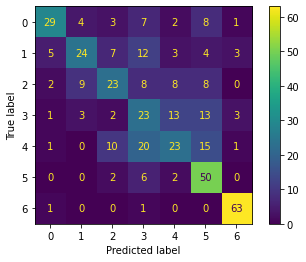

In [510]:
steps = [("hot_enc", OneHotEncoder(handle_unknown="ignore")), ("clf", LogisticRegression(random_state=42))]

pipeline = Pipeline(steps)


# Train the pipeline (tranformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transfomers & trained predictor)
predicted = pipeline.predict(X_test)

pipe_grid = {
            # "hot_enc__drop": ["first", "if_binary"],
            #"hot_enc__handle_unknown": ["ignore"],
            "clf__penalty": ["l1", "l2", "elasticnet", None],
            "clf__max_iter": [x for x in range(0, 100, 10)],
            "clf__solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
            }

# note: default scoring is aaccuracy
gs_pipe = GridSearchCV(estimator=pipeline, 
                       param_grid=pipe_grid,
                       n_jobs=-1
                       )

gs_pipe.fit(X_train, y_train)
display(gs_pipe.best_params_)
display(gs_pipe.best_score_)
display(gs_pipe.best_estimator_)

best_model = gs_pipe.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model,X_test,y_test)



2: KNN OHE

{'knn__n_neighbors': 3, 'knn__p': 1}

0.7055817955156005

Pipeline(steps=[('hot_enc', OneHotEncoder(handle_unknown='ignore')),
                ('knn', KNeighborsClassifier(n_neighbors=3, p=1))])

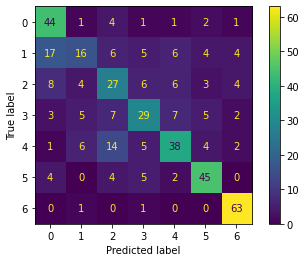

In [513]:
steps = [("hot_enc", OneHotEncoder(handle_unknown="ignore")), ("knn", KNeighborsClassifier())]

pipeline = Pipeline(steps)

# Train the pipeline (tranformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transfomers & trained predictor)
predicted = pipeline.predict(X_test)

pipe_grid = {
            #"hot_enc__handle_unknown": ["ignore", "infrequent_if_exist"],
            'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 18],
            'knn__p': [1, 2, 3, 4]
             }

# note: default scoring is aaccuracy
gs_pipe = GridSearchCV(estimator=pipeline, 
                       param_grid=pipe_grid,
                       n_jobs=-1)

gs_pipe.fit(X_train, y_train)
display(gs_pipe.best_params_)
display(gs_pipe.best_score_)
display(gs_pipe.best_estimator_)
best_model = gs_pipe.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model,X_test,y_test)

3: DT OHE

{'rf_clf__criterion': 'gini',
 'rf_clf__max_depth': 20,
 'rf_clf__max_features': 'auto',
 'rf_clf__splitter': 'best'}

0.6836672343862483

Pipeline(steps=[('hot_enc', OneHotEncoder(handle_unknown='ignore')),
                ('rf_clf',
                 DecisionTreeClassifier(max_depth=20, max_features='auto',
                                        random_state=42))])

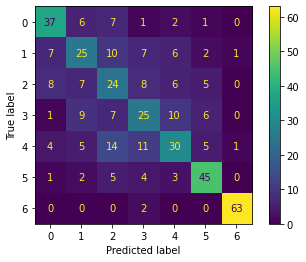

In [515]:
steps = [("hot_enc", OneHotEncoder(handle_unknown="ignore")), ('rf_clf', DecisionTreeClassifier(random_state=42))]

pipeline = Pipeline(steps)

# Train the pipeline (tranformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transfomers & trained predictor)
predicted = pipeline.predict(X_test)

pipe_grid = {
            #"hot_enc__handle_unknown": ["ignore", "infrequent_if_exist"],
            "rf_clf__criterion": ["gini", "entropy", "log_loss"],
             "rf_clf__splitter": ["best", "random"],
             "rf_clf__max_depth": [x for x in range(0,100,10)],
             "rf_clf__max_features": ["auto", "sqrt", "log2"]
            }

# note: default scoring is aaccuracy
second_pipe = GridSearchCV(estimator=pipeline, 
                       param_grid=pipe_grid,
                       n_jobs=-1)

second_pipe.fit(X_train, y_train)
display(second_pipe.best_params_)
display(second_pipe.best_score_)
display(second_pipe.best_estimator_)
best_model = second_pipe.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model,X_test,y_test)

4: RF OHE

{'rf__criterion': 'entropy',
 'rf__max_depth': 11,
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 460}

0.7464523378926483

Pipeline(steps=[('hot_enc', OneHotEncoder(handle_unknown='ignore')),
                ('rf',
                 RandomForestClassifier(criterion='entropy', max_depth=11,
                                        max_features='sqrt', n_estimators=460,
                                        random_state=42))])

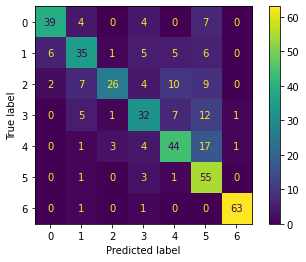

In [517]:
steps = [("hot_enc", OneHotEncoder(handle_unknown="ignore")), ('rf', RandomForestClassifier(random_state=42))]

pipeline = Pipeline(steps)

# Train the pipeline (tranformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transfomers & trained predictor)
predicted = pipeline.predict(X_test)

pipe_grid = {
            #"hot_enc__handle_unknown": ["ignore"],
            "rf__n_estimators": [x for x in range(450,500,10)],
             "rf__criterion": ["entropy"],
             "rf__max_depth": [11],
             "rf__max_features": ["sqrt"]
            }

# note: default scoring is aaccuracy
second_pipe = GridSearchCV(estimator=pipeline, 
                       param_grid=pipe_grid,
                       n_jobs=-1)

second_pipe.fit(X_train, y_train)
display(second_pipe.best_params_)
display(second_pipe.best_score_)
display(second_pipe.best_estimator_)
best_model = second_pipe.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model,X_test,y_test)

5: Boost SS

0.46335697399527187


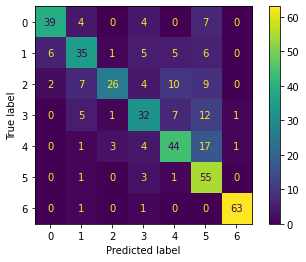

In [518]:
steps = [('std_scaler', StandardScaler()),('xgb_model', xgb.XGBClassifier())]

pipeline = Pipeline(steps)

# Train the pipeline (tranformations & predictor)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print(pipeline.score(X_test, y_test))
plot_confusion_matrix(best_model,X_test,y_test)

6: RF Poly OHE

{'rf__criterion': 'entropy',
 'rf__max_depth': 11,
 'rf__max_features': 'log2',
 'rf__n_estimators': 464}

0.7417221217495127

Pipeline(steps=[('hot_enc', OneHotEncoder(handle_unknown='ignore')),
                ('poly', PolynomialFeatures()),
                ('rf',
                 RandomForestClassifier(criterion='entropy', max_depth=11,
                                        max_features='log2', n_estimators=464,
                                        random_state=42))])

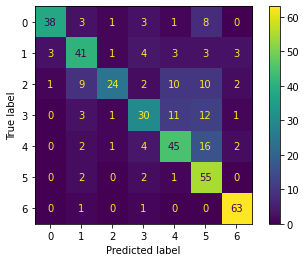

In [522]:
steps = [("hot_enc", OneHotEncoder(handle_unknown="ignore")), ("poly", PolynomialFeatures()), ('rf', RandomForestClassifier(random_state=42))]

pipeline = Pipeline(steps)

# Train the pipeline (tranformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transfomers & trained predictor)
predicted = pipeline.predict(X_test)

pipe_grid = {
            #"hot_enc__handle_unknown": ["ignore"],
            "rf__n_estimators": [464],
            "rf__criterion": ["entropy"],
            "rf__max_depth": [11],
            "rf__max_features": ["log2"]
            }

# note: default scoring is aaccuracy
second_pipe = GridSearchCV(estimator = pipeline,
                  param_grid = pipe_grid,
                  n_jobs=-1)

second_pipe.fit(X_train, y_train)
display(second_pipe.best_params_)
display(second_pipe.best_score_)
display(second_pipe.best_estimator_)
best_model = second_pipe.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model,X_test,y_test)

# BEST model SMOTE SS RF

{'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 11,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__n_estimators': 457}

0.7891015398662053

Pipeline(steps=[('smote', SMOTE(k_neighbors=1, random_state=42)),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=11,
                                        max_features='sqrt', n_estimators=457,
                                        n_jobs=-1, random_state=42))])

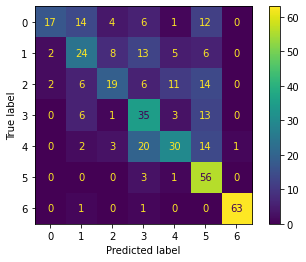

In [534]:
# Create pipeline with SMOTE, StandardScaler and RandomForestClassifier
pipeline = make_pipeline(
    # OneHotEncoder(handle_unknown="ignore", sparse=False),
    SMOTE(random_state=42, k_neighbors=1),
    StandardScaler(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

# Train the pipeline (transformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transformers & trained predictor)
predicted = pipeline.predict(X_test)

# Define the grid of hyperparameters to search over
pipe_grid = {
    "randomforestclassifier__n_estimators": [457,456,458],
    "randomforestclassifier__criterion": ["gini","entropy","log_loss"],
    "randomforestclassifier__max_depth": [x for x in range(10, 12)],
    "randomforestclassifier__max_features": ["sqrt", "log2"],
    "randomforestclassifier__class_weight": ["balanced_subsample", "balanced"],
    "randomforestclassifier__min_impurity_decrease": [0.0, 0.000001],
}

# Perform grid search to find the best combination of hyperparameters
second_pipe = GridSearchCV(
    estimator=pipeline,
    param_grid=pipe_grid,
    n_jobs=-1
)

second_pipe.fit(X_train, y_train)
display(second_pipe.best_params_)
display(second_pipe.best_score_)
display(second_pipe.best_estimator_)
best_model = second_pipe.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model,X_test,y_test)


Best so far

In [526]:
{'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__class_weight': 'balanced_subsample',
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 11,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_samples': 0.6,
 'randomforestclassifier__min_impurity_decrease': 0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 457,
 'randomforestclassifier__oob_score': True,
 'randomforestclassifier__warm_start': True}0.7369708356012853

{'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__class_weight': 'balanced_subsample',
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 11,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_samples': 0.5,
 'randomforestclassifier__min_impurity_decrease': 1e-08,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 457,
 'randomforestclassifier__oob_score': True,
 'randomforestclassifier__warm_start': True}0.7363791196249538

{'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__class_weight': 'balanced_subsample',
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 11,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_samples': 0.6,
 'randomforestclassifier__min_impurity_decrease': 0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 457,
 'randomforestclassifier__oob_score': True,
 'randomforestclassifier__warm_start': True}0.7369708356012853


SyntaxError: invalid syntax (<ipython-input-526-7f6e1d702952>, line 12)

## testing

T3: RF, SS, SMOTE

In [ ]:
{'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 11,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__min_impurity_decrease': 1e-11,
 'randomforestclassifier__n_estimators': 457}
0.7346162625322634


{'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 11,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__min_impurity_decrease': 1e-08,
 'randomforestclassifier__n_estimators': 457}

0.7891050515337208

Pipeline(steps=[('smote', SMOTE(k_neighbors=1, random_state=42)),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=11,
                                        max_features='sqrt',
                                        min_impurity_decrease=1e-08,
                                        n_estimators=457, n_jobs=-1,
                                        random_state=42))])

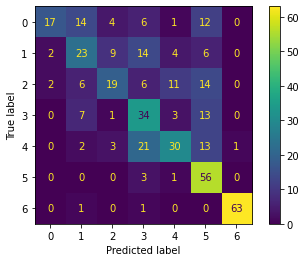

In [527]:
# Create pipeline with SMOTE, StandardScaler and RandomForestClassifier
pipeline = make_pipeline(
    # OneHotEncoder(handle_unknown="ignore", sparse=False),
    SMOTE(random_state=42, k_neighbors=1),
    StandardScaler(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

# Train the pipeline (transformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transformers & trained predictor)
predicted = pipeline.predict(X_test)

# Define the grid of hyperparameters to search over
pipe_grid = {
    "randomforestclassifier__n_estimators": [457],
    "randomforestclassifier__criterion": ["gini","entropy","log_loss"],
    "randomforestclassifier__max_depth": [11],
    "randomforestclassifier__max_features": ["sqrt","log2"],
    "randomforestclassifier__class_weight": ["balanced_subsample","balanced"],
    "randomforestclassifier__min_impurity_decrease": [0.00000001,],
}

# Perform grid search to find the best combination of hyperparameters
second_pipe = GridSearchCV(
    estimator=pipeline,
    param_grid=pipe_grid,
    n_jobs=-1
)

second_pipe.fit(X_train, y_train)
display(second_pipe.best_params_)
display(second_pipe.best_score_)
display(second_pipe.best_estimator_)
best_model = second_pipe.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model,X_test,y_test)


T5: RF, SS, SMOTE, CHAT

In [543]:
y_train.value_counts()

4    281
6    259
5    237
3    232
2    232
1    229
0    218
Name: NObeyesdad, dtype: int64

In [742]:
def gen_weights(num_cat):
    """
    Generate all possible combinations of weights for a given number of categories.

    Args:
    - num_cat (int): the number of categories to generate weights for.

    Returns:
    - A list of dictionaries, where each dictionary represents a unique combination of weights for each category.
      The keys of each dictionary are the category numbers (0 to num_cat - 1) and the values are the weights for each category.
    """
    master_weights = []
    weights = {}
    for cat in range(num_cat):
        weights.update({cat: 1})

    for i in range(num_cat):
        weight_values = list(np.arange(1, 1.3, 0.30))
        weight_combinations = list(itertools.product(weight_values, repeat=num_cat))
        for combination in weight_combinations:
            temp_weights = weights.copy()
            for j in range(num_cat):
                temp_weights[j] = combination[j]
            master_weights.append(temp_weights.copy())
            
    return list(map(dict, set(frozenset(d.items()) for d in master_weights)))

weights = gen_weights(7)
len(weights)

128

{'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__class_weight': {0: 1.0,
  3: 1.3,
  1: 1.3,
  6: 1.3,
  5: 1.0,
  4: 1.3,
  2: 1.3},
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 11,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_samples': 0.6,
 'randomforestclassifier__min_impurity_decrease': 0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 456,
 'randomforestclassifier__oob_score': True,
 'randomforestclassifier__warm_start': True}

0.7896985233438099

Pipeline(steps=[('smote', SMOTE(k_neighbors=1, random_state=42)),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight={0: 1.0, 1: 1.3, 2: 1.3,
                                                      3: 1.3, 4: 1.3, 5: 1.0,
                                                      6: 1.3},
                                        criterion='entropy', max_depth=11,
                                        max_features='sqrt', max_samples=0.6,
                                        min_impurity_decrease=0,
                                        n_estimators=456, oob_score=True,
                                        random_state=42, warm_start=True))])

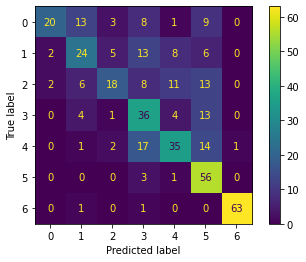

In [744]:
# Create pipeline with SMOTE, StandardScaler and RandomForestClassifier
pipeline = make_pipeline(
    # OneHotEncoder(handle_unknown="ignore", sparse=False),
    SMOTE(random_state=42, k_neighbors=1),
    StandardScaler(),
    RandomForestClassifier(random_state=42)
)

# Train the pipeline (transformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transformers & trained predictor)
predicted = pipeline.predict(X_test)

# Define the grid of hyperparameters to search over
pipe_grid = {
    "randomforestclassifier__n_estimators": [456],
    "randomforestclassifier__criterion": ["entropy"],
    "randomforestclassifier__max_depth": [11],
    "randomforestclassifier__max_features": ["sqrt"],
    "randomforestclassifier__class_weight": weights[:5],
    "randomforestclassifier__min_impurity_decrease": [0],
    "randomforestclassifier__min_samples_split": [2],
    "randomforestclassifier__min_samples_leaf": [1],
    "randomforestclassifier__max_samples": [0.6],
    "randomforestclassifier__bootstrap": [True],
    "randomforestclassifier__oob_score": [True],
    "randomforestclassifier__warm_start": [True]
}

# Perform grid search to find the best combination of hyperparameters
second_pipe = GridSearchCV(
    estimator=pipeline,
    param_grid=pipe_grid,
    n_jobs=-1
)

second_pipe.fit(X_train, y_train)
display(second_pipe.best_params_)
display(second_pipe.best_score_)
display(second_pipe.best_estimator_)
best_model = second_pipe.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model,X_test,y_test)

T1: Log, RF, SS, SMOTE

In [529]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import SMOTE

# Define the pipeline for the resampler and classifier
resamp_clf_pipeline = Pipeline([
        ('smote', SMOTE(random_state=42, k_neighbors=1)),
        ('clf', RandomForestClassifier(random_state=42))
    ])

# Define the main pipeline
pipeline = Pipeline([
    ('resamp_clf_pipeline', resamp_clf_pipeline),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=42))
])

# Train the pipeline (transformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transformers & trained predictor)
predicted = pipeline.predict(X_test)

# Define the grid of hyperparameters to search over
pipe_grid = {
    "resamp_clf_pipeline__smote__sampling_strategy": ["minority", "not minority"],
    "resamp_clf_pipeline__smote__random_state": [42],
    "resamp_clf_pipeline__randomforestclassifier__n_estimators": [457],
    "resamp_clf_pipeline__randomforestclassifier__criterion": ["entropy"],
    "resamp_clf_pipeline__randomforestclassifier__max_depth": [11],
    "resamp_clf_pipeline__randomforestclassifier__max_features": ["log2"],
    "clf__penalty": ["l1", "l2", "elasticnet", None],
    "clf__max_iter": [x for x in range(0, 100, 10)],
    "clf__solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
}

# Perform grid search to find the best combination of hyperparameters
second_pipe = GridSearchCV(
    estimator=pipeline,
    param_grid=pipe_grid
)

second_pipe.fit(X_train, y_train)

display(second_pipe.best_params_)
display(second_pipe.best_score_)
display(second_pipe.best_estimator_)
best_model = second_pipe.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model,X_test,y_test);


TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'SMOTE(k_neighbors=1, random_state=42)' (type <class 'imblearn.over_sampling._smote.SMOTE'>) doesn't

T2: ManualOverSamp, SS, RF

{'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 11,
 'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__n_estimators': 457,
 'randomoversampler__sampling_strategy': {0: 281,
  1: 281,
  2: 281,
  3: 281,
  4: 281,
  5: 300,
  6: 259}}

0.7920636314153775

Pipeline(steps=[('randomoversampler',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy={0: 281, 1: 281, 2: 281,
                                                      3: 281, 4: 281, 5: 300,
                                                      6: 259})),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=11,
                                        max_features='log2', n_estimators=457,
                                        random_state=42))])

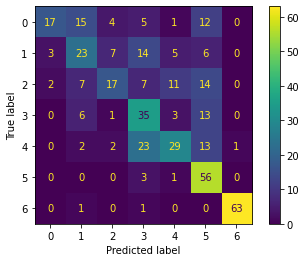

In [532]:
# Define the pipeline
pipeline = make_pipeline(
    RandomOverSampler(random_state=42),
    StandardScaler(),
    RandomForestClassifier(random_state=42)
)

# Train the pipeline (transformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transformers & trained predictor)
predicted = pipeline.predict(X_test)

# Define the grid of hyperparameters to search over
pipe_grid = {
    "randomoversampler__sampling_strategy": [{0:281,1:281,2:281,3:281,4:281,5:300,6:259}],
    "randomforestclassifier__n_estimators": [457],
    "randomforestclassifier__criterion": ["entropy"],
    "randomforestclassifier__max_depth": [11],
    "randomforestclassifier__max_features": ["log2"],
    "randomforestclassifier__class_weight": ["balanced", "balanced_subsample"]
}

# Perform grid search to find the best combination of hyperparameters
second_pipe = GridSearchCV(
    estimator=pipeline,
    param_grid=pipe_grid,
    n_jobs=-1
)

second_pipe.fit(X_train, y_train)
display(second_pipe.best_params_)
display(second_pipe.best_score_)
display(second_pipe.best_estimator_)
best_model = second_pipe.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model,X_test,y_test);


T4: OverSamp, SS, RF

{'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 11,
 'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__n_estimators': 457,
 'randomoversampler__sampling_strategy': 'not minority'}

0.7885063122223588

Pipeline(steps=[('randomoversampler',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy='not minority')),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=11,
                                        max_features='log2', n_estimators=457,
                                        random_state=42))])

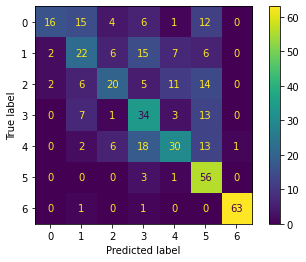

In [533]:
# Define the pipeline
pipeline = make_pipeline(
    RandomOverSampler(random_state=42),
    StandardScaler(),
    RandomForestClassifier(random_state=42)
)

# Train the pipeline (transformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transformers & trained predictor)
predicted = pipeline.predict(X_test)

# Define the grid of hyperparameters to search over
pipe_grid = {
    "randomoversampler__sampling_strategy": ["minority","minority","minority","minority","minority","minority","not minority"],
    "randomforestclassifier__n_estimators": [457],
    "randomforestclassifier__criterion": ["entropy"],
    "randomforestclassifier__max_depth": [11],
    "randomforestclassifier__max_features": ["log2"]
}

# Perform grid search to find the best combination of hyperparameters
second_pipe = GridSearchCV(
    estimator=pipeline,
    param_grid=pipe_grid,
)

second_pipe.fit(X_train, y_train)
display(second_pipe.best_params_)
display(second_pipe.best_score_)
display(second_pipe.best_estimator_)
best_model = second_pipe.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model,X_test,y_test);


## end testing